# Spherical Gaussian experiment: generative results

## Setup

In [18]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging
import corner

sys.path.append("../../")

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [2]:
algo_filenames = ["flow", "pie", "mf", "slice", "gamf", "hybrid"]
algo_labels = ["Standard flow", "PIE", "Manifold flow", "Slice", "GAMF", "Hybrid"]

setup_filenames = [
    "2_3_0.010",
    "2_3_0.001",
    "2_3_0.100",
]
setup_labels = [
    r"2-sphere in 3 dim., $\epsilon = 0.01$",
    r"2-sphere in 3 dim., $\epsilon = 0.001$",
    r"2-sphere in 3 dim., $\epsilon = 0.1$",
]


In [4]:
result_dir = "../data/results"

x_gen = []
logp_gen = []
distance_gen = []

for algo_filename in algo_filenames:
    x_gen_ = []
    logp_gen_ = []
    distance_gen_ = []
    for setup_filename in setup_filenames:
        try:
            x_gen_.append(np.load(
                "{}/{}_2_spherical_gaussian_{}_samples.npy".format(result_dir, algo_filename, setup_filename)
            ))
        except FileNotFoundError as e:
            print(e)
            x_gen_.append(None)
            
        try:
            logp_gen_.append(np.load(
                "{}/{}_2_spherical_gaussian_{}_samples_likelihood.npy".format(result_dir, algo_filename, setup_filename)
            ))
        except:
            logp_gen_.append(np.nan*np.ones(1000))
            
        try:
            distance_gen_.append(np.load(
                "{}/{}_2_spherical_gaussian_{}_samples_manifold_distance.npy".format(result_dir, algo_filename, setup_filename)
            ))
        except:
            distance_gen_.append(np.nan*np.ones(1000))
            
    x_gen.append(x_gen_)
    logp_gen.append(logp_gen_)
    distance_gen.append(distance_gen_)
    
logp_gen = np.asarray(logp_gen)
distance_gen = np.asarray(distance_gen)


In [16]:
min_logp = -100.
max_distance = 10.

mean_logp_gen = np.median(np.clip(logp_gen, min_logp, None), axis=2)
mean_distance_gen = np.median(np.clip(distance_gen, None, max_distance), axis=2)


## Plot generated samples

In [64]:
def show_corner(algo=None, show=0, boundary=3.):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_test.npy")
        print(x.shape[0])
        _ = corner.corner(x, range=[(-boundary, boundary) for _ in range(3)])
        
    else:
        print(algo_labels[algo])
        print(x_gen[algo][show].shape[0])
        _ = corner.corner(x_gen[algo][show], range=[(-boundary, boundary) for _ in range(3)])

Simulator
1000


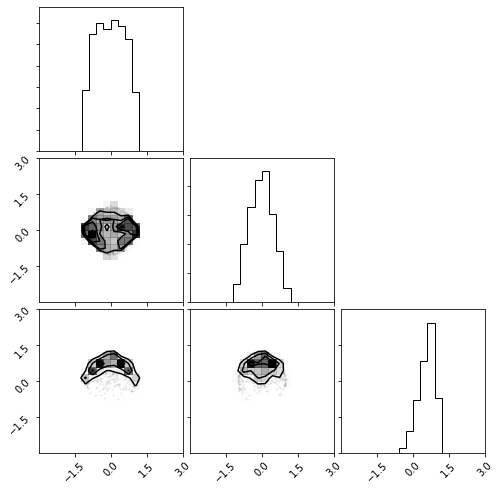

In [65]:
show_corner()

Standard flow
1000


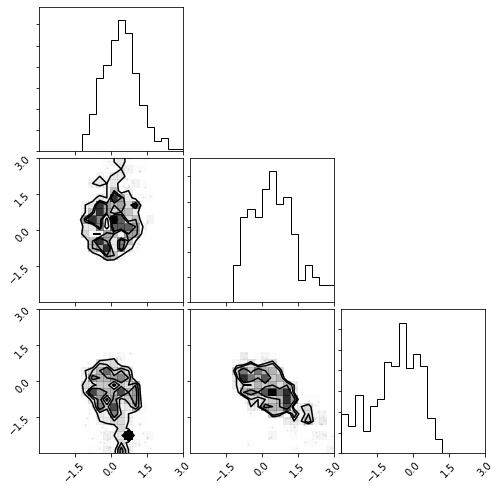

In [66]:
show_corner(0)

PIE
1000


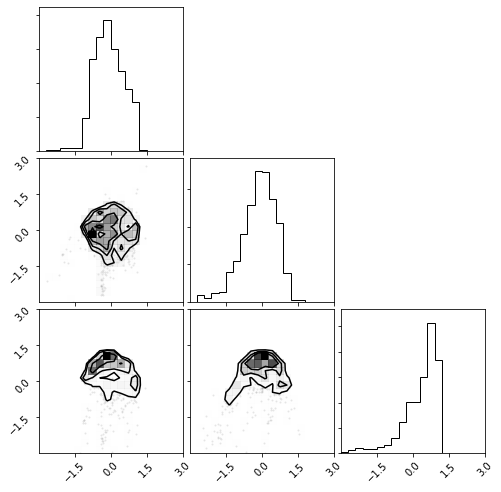

In [67]:
show_corner(1)

Manifold flow
1000


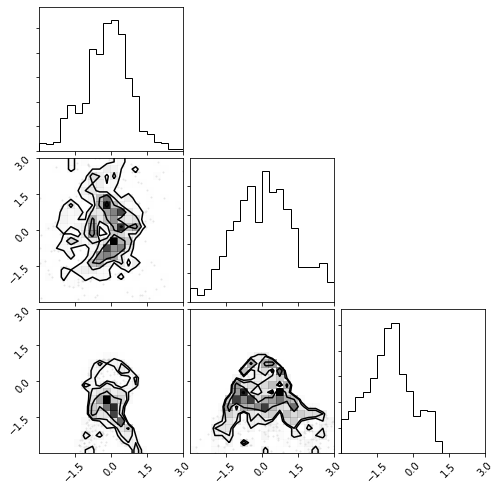

In [68]:
show_corner(2)

GAMF
1000


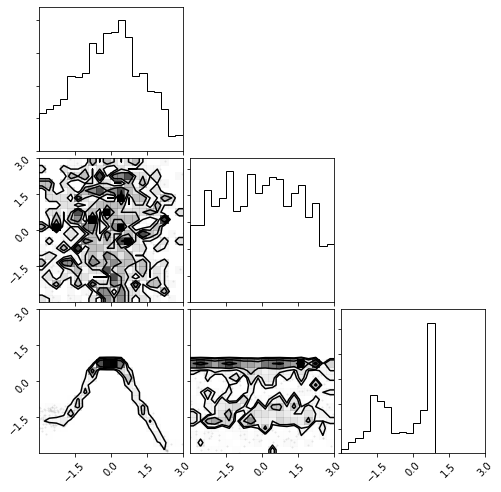

In [69]:
show_corner(4)

Hybrid
1000


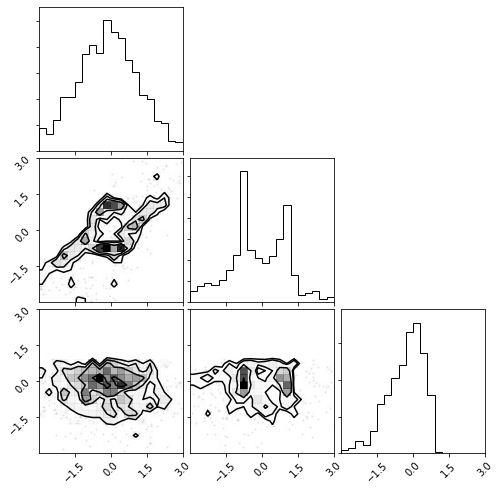

In [70]:
show_corner(5)

## Plot results

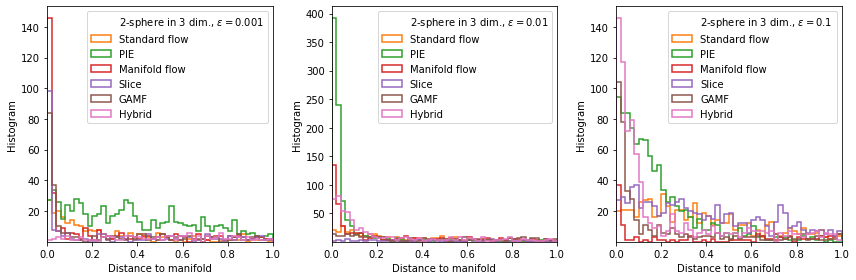

In [12]:
show = [1,0,2]
ncols = 3
nrows = (len(show) - 1) // ncols + 1

xmin, xmax = 0.,1.

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, setting in enumerate(show):
    ax = plt.subplot(nrows, ncols, panel + 1)
    
    plt.plot([], [], lw=0., ls=" ", label=setup_labels[setting])
    
    for algo, algo_label in enumerate(algo_labels):
        plt.hist(
            distance_gen[algo, setting,:],
            range=(xmin, xmax), bins=50,
            label=algo_label,
            histtype="step",
            lw=1.5
        )
        
    plt.legend()

    plt.xlabel(r"Distance to manifold")
    plt.ylabel(r"Histogram")
    plt.xlim(xmin, xmax)
    plt.ylim(1.e-3, None)
    
plt.tight_layout()
plt.savefig("../figures/distance_distribution_spherical_gaussian.pdf")


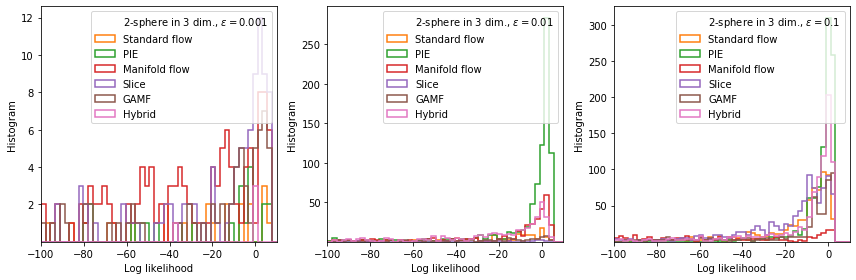

In [14]:
show = [1,0,2]
ncols = 3
nrows = (len(show) - 1) // ncols + 1

xmin, xmax = -100.,10.

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, setting in enumerate(show):
    ax = plt.subplot(nrows, ncols, panel + 1)
    
    plt.plot([], [], lw=0., ls=" ", label=setup_labels[setting])
    
    for algo, algo_label in enumerate(algo_labels):
        plt.hist(
            logp_gen[algo, setting,:],
            range=(xmin, xmax), bins=50,
            label=algo_label,
            histtype="step",
            lw=1.5
        )
        
    plt.legend()

    plt.xlabel(r"Log likelihood")
    plt.ylabel(r"Histogram")
    plt.xlim(xmin, xmax)
    plt.ylim(1.e-3, None)
    
plt.tight_layout()
plt.savefig("../figures/likelihood_distribution_spherical_gaussian.pdf")



[-100.         -100.          -15.52103678]
[-100.           -0.39914807   -0.47307929]
[-100. -100. -100.]
[-100.         -100.          -11.66295576]
[-100. -100. -100.]
[-100.         -100.           -4.81267317]
[10.          9.219567    0.53563106]
[0.5407783  0.02696568 0.12905824]
[2.0840678 1.1394132 2.5341535]
[3.1104276  5.350519   0.42040396]
[2.6050706 1.9306977 1.5288565]
[5.3523903  0.6247019  0.11041173]


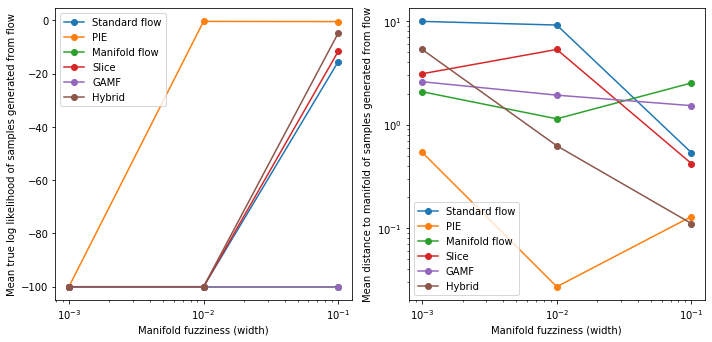

In [17]:
show = [1, 0, 2]
xs = [0.001, 0.01, 0.1]

fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
for mean_logp_gen_, algo_label in zip(mean_logp_gen, algo_labels):
    print(mean_logp_gen_[show])
    plt.plot(xs, mean_logp_gen_[show], label=algo_label, ls="-", marker="o", ms=6.)
plt.legend()
plt.xscale("log")
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("Mean true log likelihood of samples generated from flow")

ax = plt.subplot(1,2,2)
for mean_distance_gen_, algo_label in zip(mean_distance_gen, algo_labels):
    print(mean_distance_gen_[show])
    plt.plot(xs, mean_distance_gen_[show], label=algo_label, ls="-", marker="o", ms=6.)
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("Mean distance to manifold of samples generated from flow")

plt.tight_layout()
plt.savefig("../figures/distance_likelihood_vs_epsilon_spherical_gaussian.pdf")
